# Introduction

***Aim and outline***

This notebook utilizes a dataset containing the results of the chemical analysis of Italian wines to **explore a range of clustering algorithms**. The dataset is small and fairly simple.

The following algorithms are applied and then compared:
- **K-means**, a centroid-based algo
- **Mean shift**, a centroid-based algo
- **Gaussian mixture**, a distribution-based algo
- **Affinity propagation**
- **DBSCAN**, a density-based algo
- **OPTICS**, a density-based algo

See https://developers.google.com/machine-learning/clustering/clustering-algorithms for a brief description of how to categorize clustering algos.

In order to keep this notebook reasonably compact, **only the most important hyperparameter will be tuned for each algo**.

The very brief EDA section of this notebook is identical to the one of an earlier notebook of mine, https://www.kaggle.com/code/dexmasa/clustering-wine-k-means-pca-or-umap/notebook, and just reproduced here for the sake of context and convenience.

When it comes to getting an idea of what a particular clustering algorithm does and how it does it, I found it very useful to look at the visualisation of its "steps". Here the link to one such visualisations I found quite useful: https://www.digitalvidya.com/blog/the-top-5-clustering-algorithms-data-scientists-should-know/



***Link to dataset***

https://www.kaggle.com/datasets/harrywang/wine-dataset-for-clustering


***Data dictionary (from above source)***

Features (all numercial):
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline


In [121]:
!pip install --upgrade umap-learn

**Imports and global settings**

In [122]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

# EDA

**Reading in the dataset**

In [123]:
#df = pd.read_csv("../input/wine-dataset-for-clustering/wine-clustering.csv")
df = pd.read_csv("penguins.csv")

df.head()


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


**Any duplicate rows?**

In [124]:
n_dup = len(df) - len(df.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 1


**Any missing values?**

In [125]:
df.isnull().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

**Checking data types**

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


**Cleaning up column names (mainly for handling purposes)**

In [127]:
cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower())

df.columns = cols_cleaned

# sanity check
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [128]:
#Eliminar Filas que tengan Nan
df = df.dropna()

**Quick overview over the individual distributions**

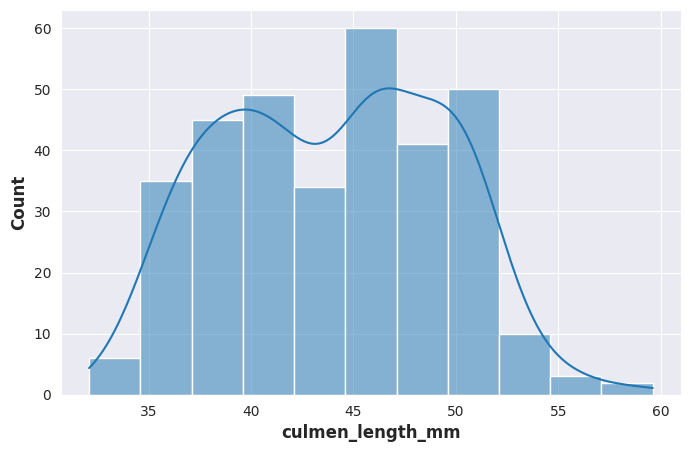

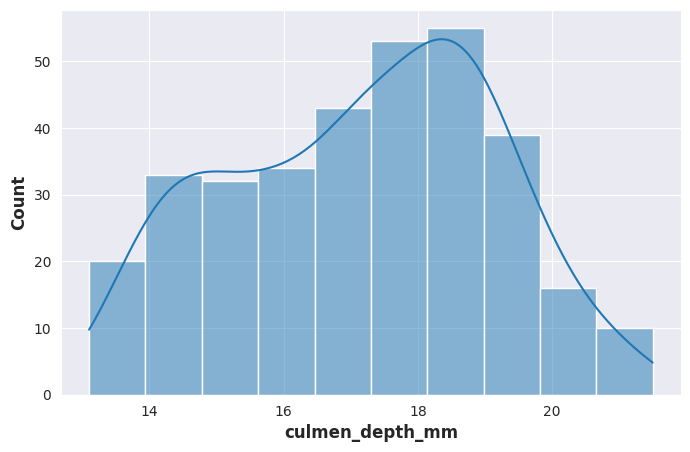

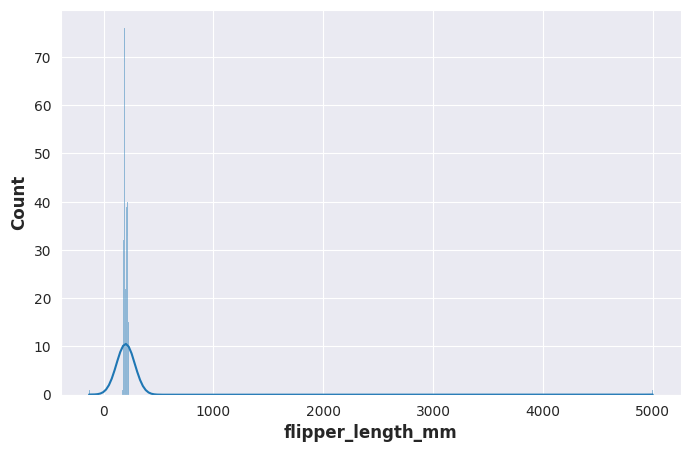

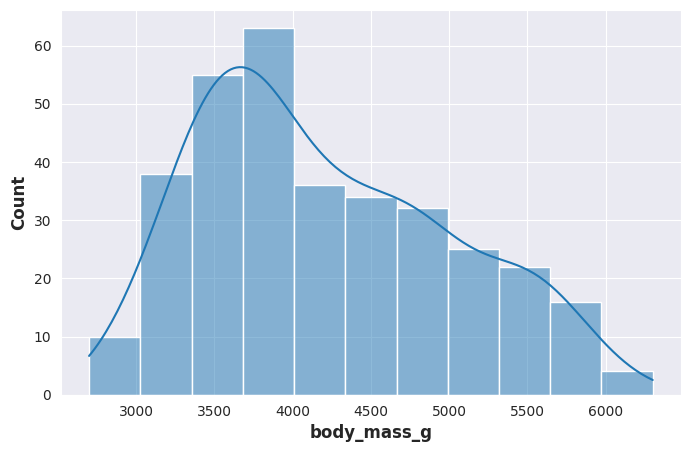

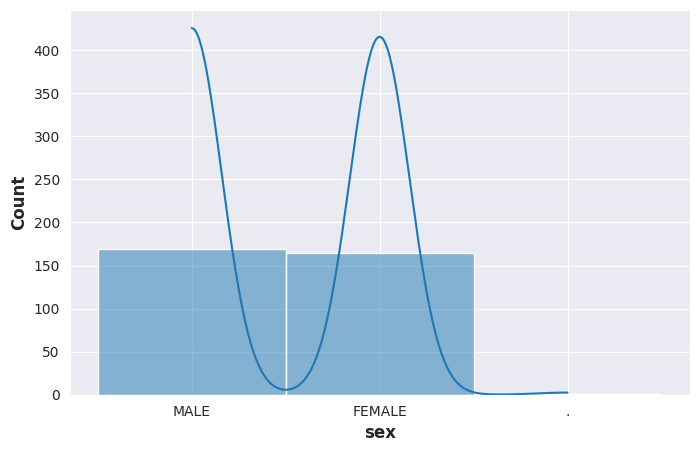

In [129]:
for col in df.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()

==> Distributions require scaling and standardization.

# Clustering

In [130]:
algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]

# saving training times for each algo
training_times = []

## Scaling and Standardizing

In [131]:
from sklearn.preprocessing import LabelEncoder

# Crear un LabelEncoder
label_encoder = LabelEncoder()

# Ajustar y transformar la columna
df['sex_numerica'] = label_encoder.fit_transform(df['sex'])
df = df.drop(columns=['sex'])
print(df)

     culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
0                39.1             18.7              181.0       3750.0   
1                39.5             17.4              186.0       3800.0   
2                40.3             18.0              195.0       3250.0   
4                36.7             19.3              193.0       3450.0   
5                39.3             20.6              190.0       3650.0   
..                ...              ...                ...          ...   
338              47.2             13.7              214.0       4925.0   
340              46.8             14.3              215.0       4850.0   
341              50.4             15.7              222.0       5750.0   
342              45.2             14.8              212.0       5200.0   
343              49.9             16.1              213.0       5400.0   

     sex_numerica  
0               2  
1               1  
2               1  
4               1  
5          

In [132]:
X = StandardScaler().fit_transform(df)

In [133]:
X = PowerTransformer(standardize=False).fit_transform(X)

In [134]:
X = pd.DataFrame(X, columns=df.columns)

# sanity check
X.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_numerica
0,-0.903807,0.812863,-0.138432,-0.631725,1.027896
1,-0.829475,0.117974,-0.116190,-0.557615,-0.950424
2,-0.680984,0.433050,-0.077491,-1.434105,-0.950424
3,-1.350886,1.147206,-0.085943,-1.100422,-0.950424
4,-0.866634,1.894641,-0.098779,-0.783481,1.027896


## Dimensionality reduction via UMAP

Prior to clustering, the number of features is reduced from 13 to 2. The main reason behind this is to be able to **directly "see" if the identified clusters make sense**. In addition to this, (i) similarity metrics tend to work better in lower dimensions (distance measures degenerate for large numbers of input features), and (ii) this dimensionality reduction also mitigates the relatively poor "obervations to features ratio" for this dataset.

In [135]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

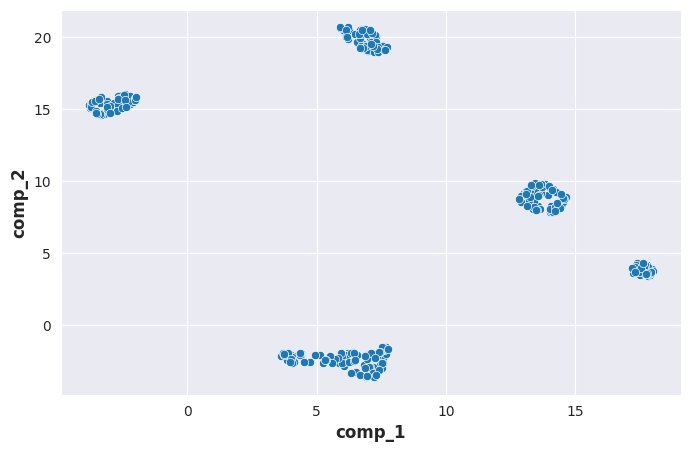

In [136]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

==> The structure of this dataset is fairly straight-forward. One would expect a clustering algo to find 3 clusters here.

## Definition of plotting and convergence check function

In [137]:
# function to visualize identified clusters

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):
    """Visualisation of identified clusters. Only a single hyperparameter is considered.

    Arguments
    =========
    df: pandas.DataFrame
        Dataframe of input features.
    labels_all: list | numpy.array
        Identified cluster IDs.
    hyperparam_name: str | None
        Name of hyperparameter.
    hyperparam_val: float | int | None
        Value of hyperparameter.
    noise_exist: bool
        True if algo models noise, False otherwise.
        Assumes encoding of noise as cluster ID = -1.

    Returns
    =======
    None
    Prints a figure.

    """

    # Checking of input parameters omitted for this notebook

    labels = sorted(pd.Series(labels_all).unique())

    if noise_exist:

        outlier_perc = int(round(( (len(df) - sum(np.where(labels_all == -1, False, True))) / len(df) ) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"
            else:
                marker_style = "o"
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Noise': {outlier_perc}%")
        else:
            plt.title(f"Defaults for all hyperparameters; 'Noise': {outlier_perc}%")
        plt.legend(title="cluster ID")
        plt.show()

    else:

        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Defaults for all hyperparameters")
        plt.legend(title="cluster ID")
        plt.show()


def convergence_check(model):
    """Checking if fitted model converged within the max. number of iterations."""
    if model.n_iter_ < model.max_iter:
        print(f"Algorithm converged successfully!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"WARNING: Algorithm did not converge within {model.max_iter} iterations!\n")

## Algo 1: K-means

K-means is the most well-known and "basic" clustering algorithm.
Its most important hyperparamter is ***n_clusters***, which is the number of clusters for the algo to look for.

In [138]:
# hyperparameter to tune

kmeans_hparam = "n_clusters"

### Identifying the "optimal" number of clusters

In the context of clustering via K-means, the sum of squared distances of points to their respective centroid is known as "**inertia**". Finding an appropriate number of clusters here means finding the point of diminishing returns when increasing the number of centroids. This is done visually via identifying a potential kink in the inertia vs. number of clusters plot.

In [139]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

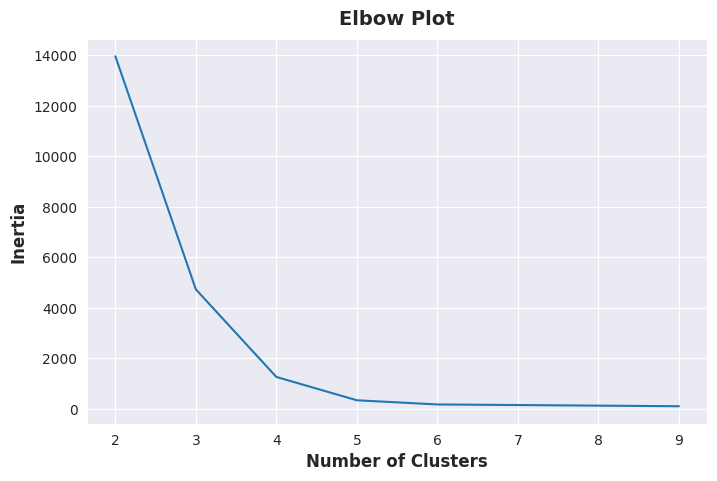

In [140]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

==> Salient "kink" at 3 clusters. This is thus the number of clusters to go for. As discussed above, this is along the lines of what is to be expected by just looking at the data.

### Run with optimised *n_clusters*

In [141]:
%%time

start_time = time.time()

kmeans = KMeans(n_clusters=3, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 2, max_iter: 300

CPU times: user 34 ms, sys: 999 µs, total: 35 ms
Wall time: 43.6 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


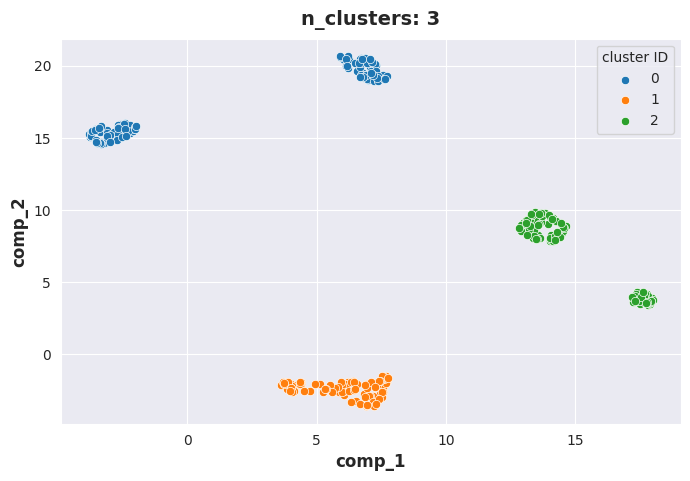

In [142]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=3, noise_exist=False)

==> Those results seem very reasonable. This is not unexpectd as the structure of the data is such that it does not collide with the fundamental assumptions of K-means, namely that the clusters form **non-overlapping (hyper)spheres** (i.e. "circles" in 2D) of **roughly the same extent** (and the dataset is does not contain an "excessive" number of outliers).

## Algo 2: Mean shift

Similar to K-means, Mean shift is a centroid-based algorithm. In contrast to K-means, however, there is **no requirement to specify the number of clusters upfront**. Its main hyperparameter is ***bandwidth***, which represents the extent of the "local search regions". If this parameter is not specified, however, sklearn does provide an estimation for it. Additionally, Mean shift also comes with the option to not necessarily associate all data points with a cluster via setting *cluster_all* to *False*. This aspect of the alogrithm is also explored in the following.

In [143]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

### Vanilla run (defaults for all hyperparameters)

In [144]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Algorithm converged successfully!
n_iter: 2, max_iter: 300

CPU times: user 446 ms, sys: 114 ms, total: 561 ms
Wall time: 4.85 s


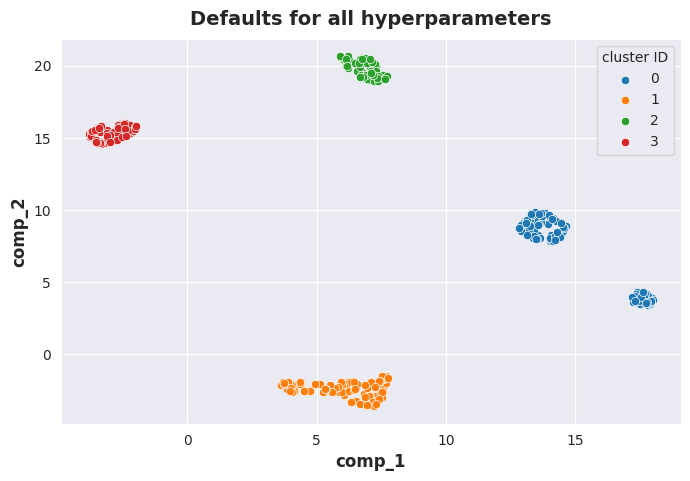

In [145]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

==> The estimation for *bandwidth* seems to work well here. There is thus no need for any further tuning of this hyperparameter.

### Allowing for 'noise'

This is enabled by setting *cluster_all=False*.

In [146]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

Algorithm converged successfully!
n_iter: 2, max_iter: 300

CPU times: user 194 ms, sys: 16 ms, total: 210 ms
Wall time: 836 ms


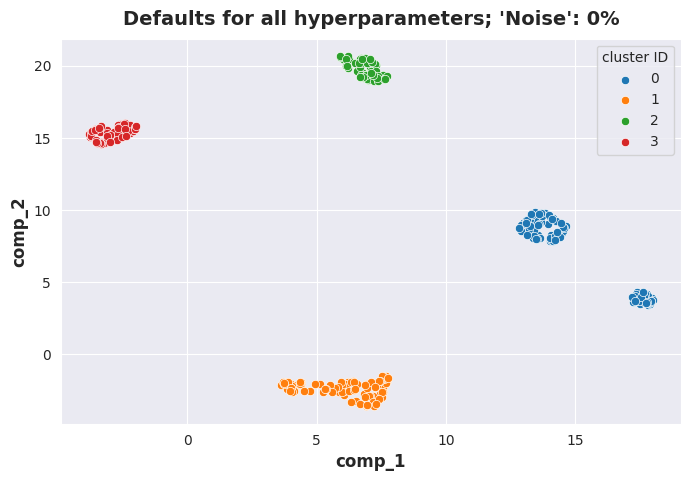

In [147]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Data points that the algorithm identifies as "not being part of any cluster" (i.e. 'noise' or 'orphans') are marked as blue stars (cluster ID: -1).

==> Results look sensible but not substantially different to the solution for the default *cluster_all=True* for this dataset.

## Algo 3: Gaussian Mixture

The Gaussian mixture model is, as the name suggests, a distribution-based algorithm. Its main hyperparamter is ***n_components***, which corresponds to the number of clusters to form. As a shortcut here, the number of clusters as identified in the K-means section is adopted.

In [148]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [149]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)

labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 2, max_iter: 100

CPU times: user 93.3 ms, sys: 4.98 ms, total: 98.3 ms
Wall time: 127 ms


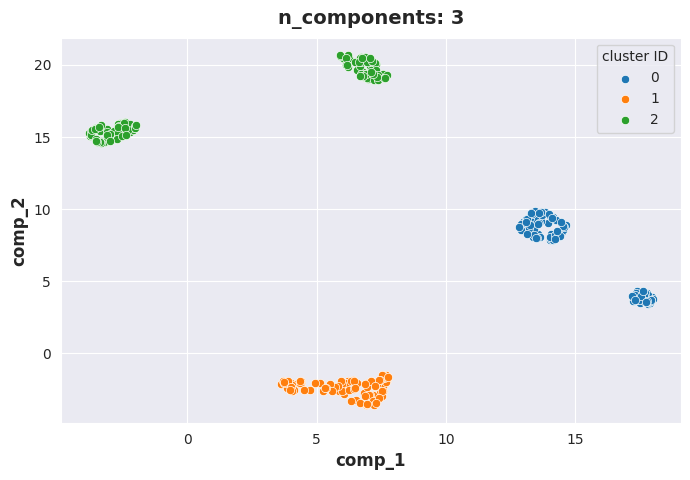

In [150]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=3, noise_exist=False)

==> The results look quite reasonable. This is, again, not completely unexpected as the structure of the data does form more of less **elliptic "blobs"** in 2D, which is what the Gaussian mixture model is quite good at capturing.

## Algo 4: Affinity propagation

Affinity propagation does not require specifying the number of clusters upfront. Its main hyperparameter is ***damping***, which is a value in the range of 0.5 (incl.) to 1.0 (excl.).

In [151]:
# hyperparamter to tune

affprop_hparam = "damping"

### Vanilla run (defaults for all hyperparameters)

In [152]:
%%time

affprop = AffinityPropagation(random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)


CPU times: user 450 ms, sys: 3.88 ms, total: 454 ms
Wall time: 528 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


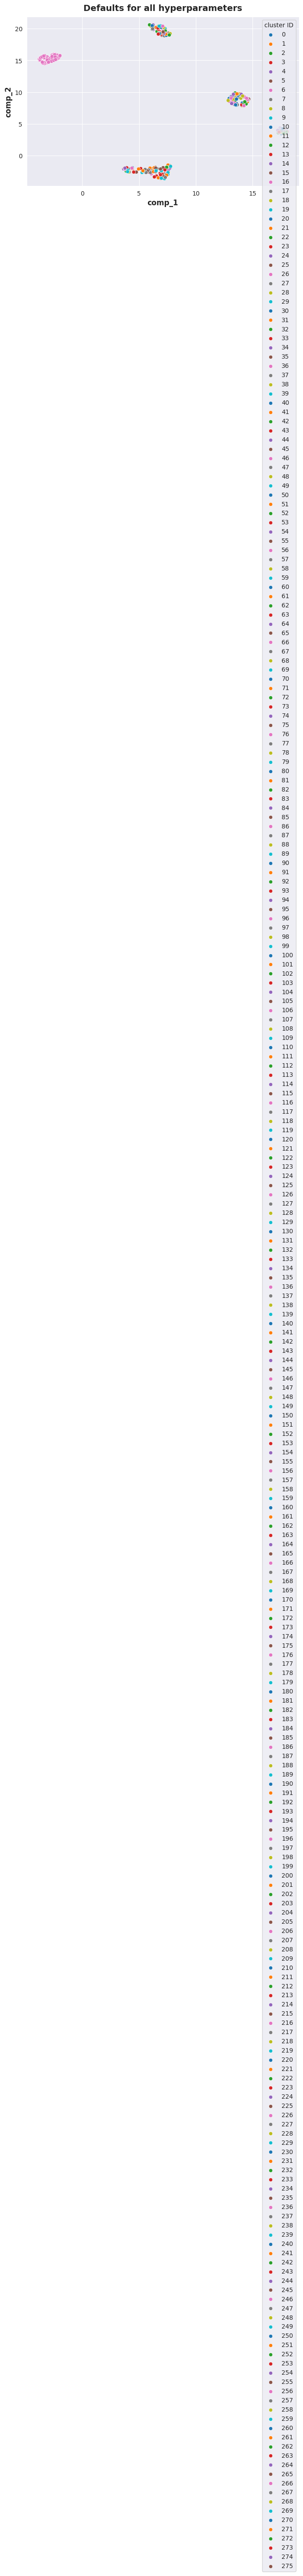

In [153]:
visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

==> The vanilla algo finds a lot more clusters than the 3 that were expected. There is a possibility, however, that those "additional" clusters actually represent something that could be of interest here, but this is beyond the scope of this exercise.

### Tuning runs for "damping"

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


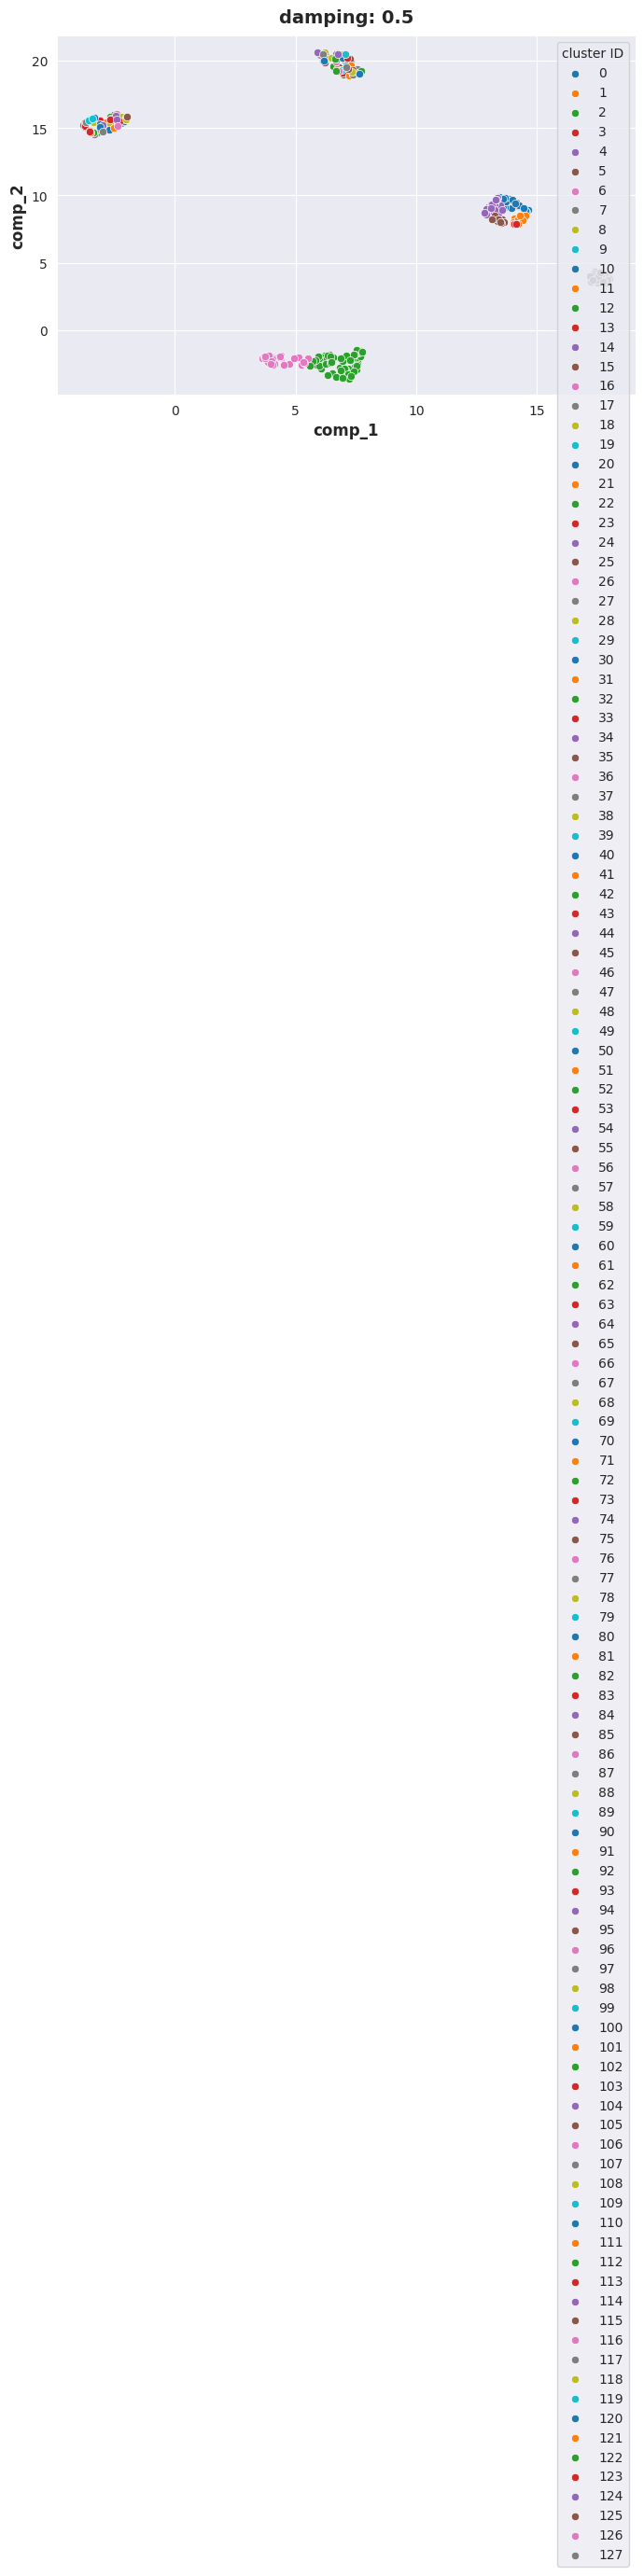

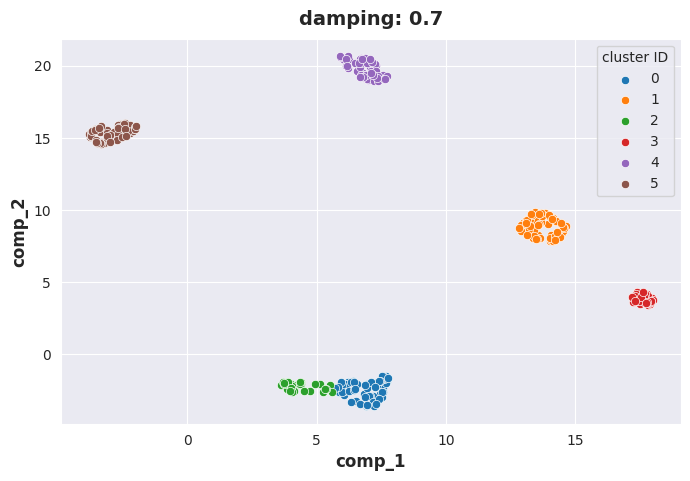

Algorithm converged successfully!
n_iter: 54, max_iter: 500



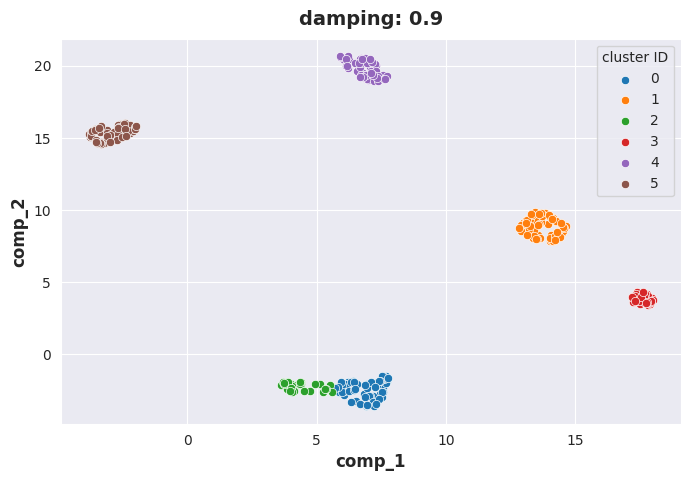

Algorithm converged successfully!
n_iter: 43, max_iter: 500



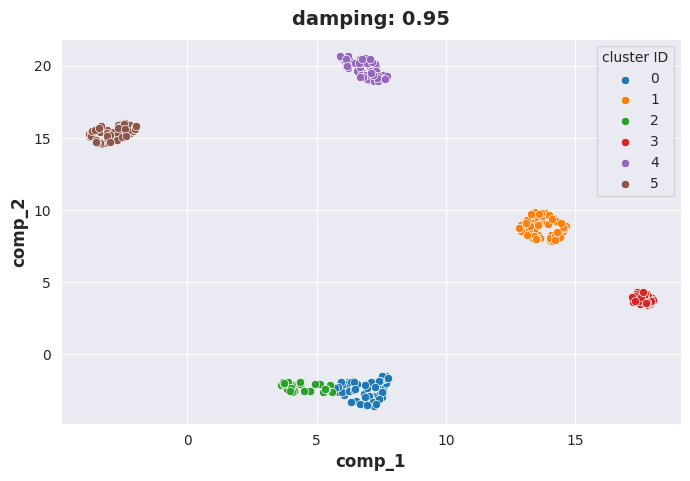

Algorithm converged successfully!
n_iter: 71, max_iter: 500



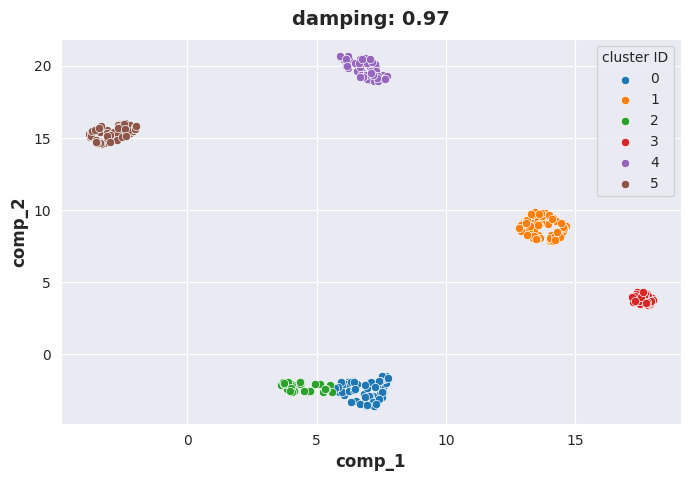

Algorithm converged successfully!
n_iter: 109, max_iter: 500



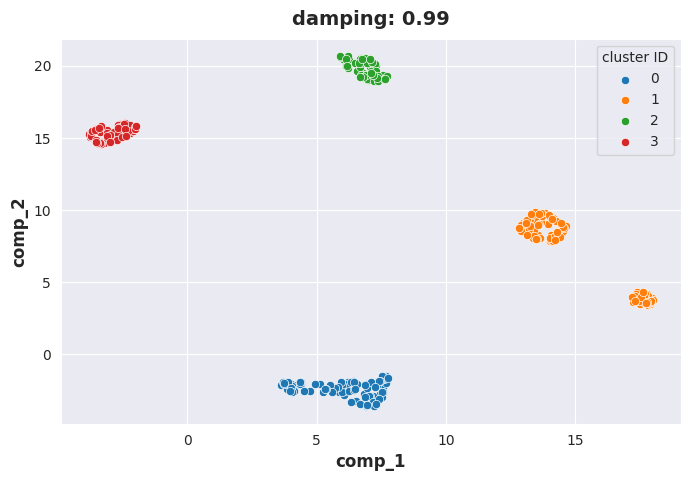

Algorithm converged successfully!
n_iter: 281, max_iter: 500

CPU times: user 19.7 s, sys: 689 ms, total: 20.4 s
Wall time: 20.3 s


In [154]:
%%time

damps = [0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

for d in damps:
    affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
    convergence_check(affprop)

==> Tuning "damping" does not seem to be very "effective" for this dataset!

### Tuning runs for "preference"

In order to still get to the "expected solution" of finding 3 clusters, another hyperparamter, ***preference*** is investigated. As stated in the beginning though, the self-imposed contraint here is to only tune a single hyperparameter, leaving all others at their default values, i.e. not looking for any interactions between them.

In [155]:
# hyperparamter to tune

affprop_hparam = "preference"

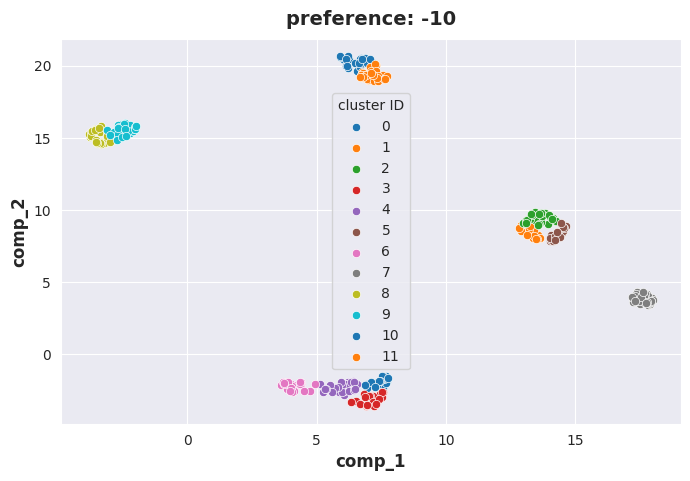

Algorithm converged successfully!
n_iter: 45, max_iter: 500



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


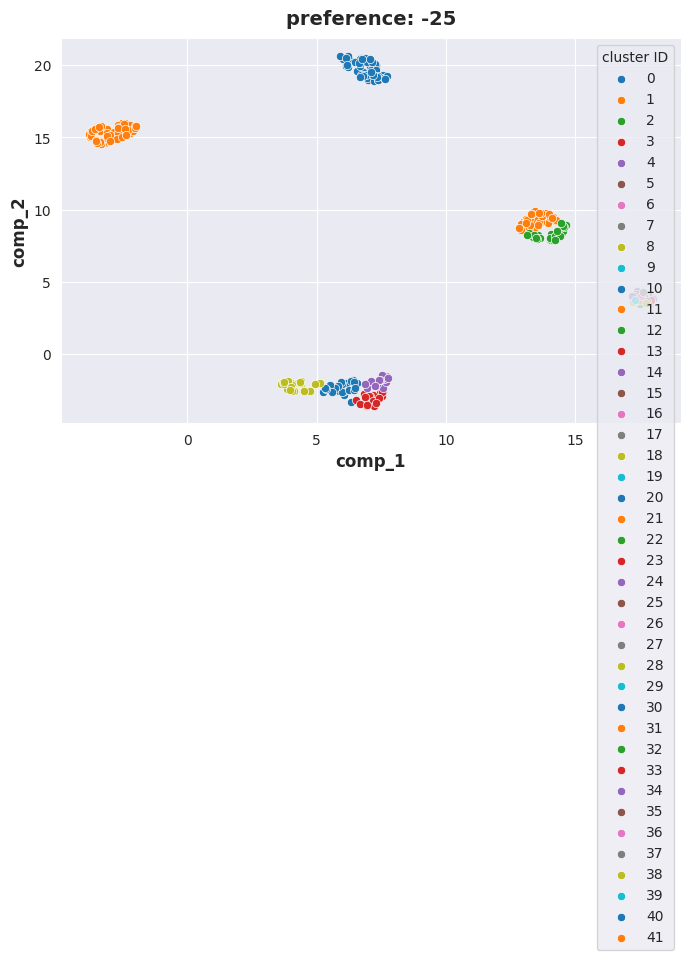

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


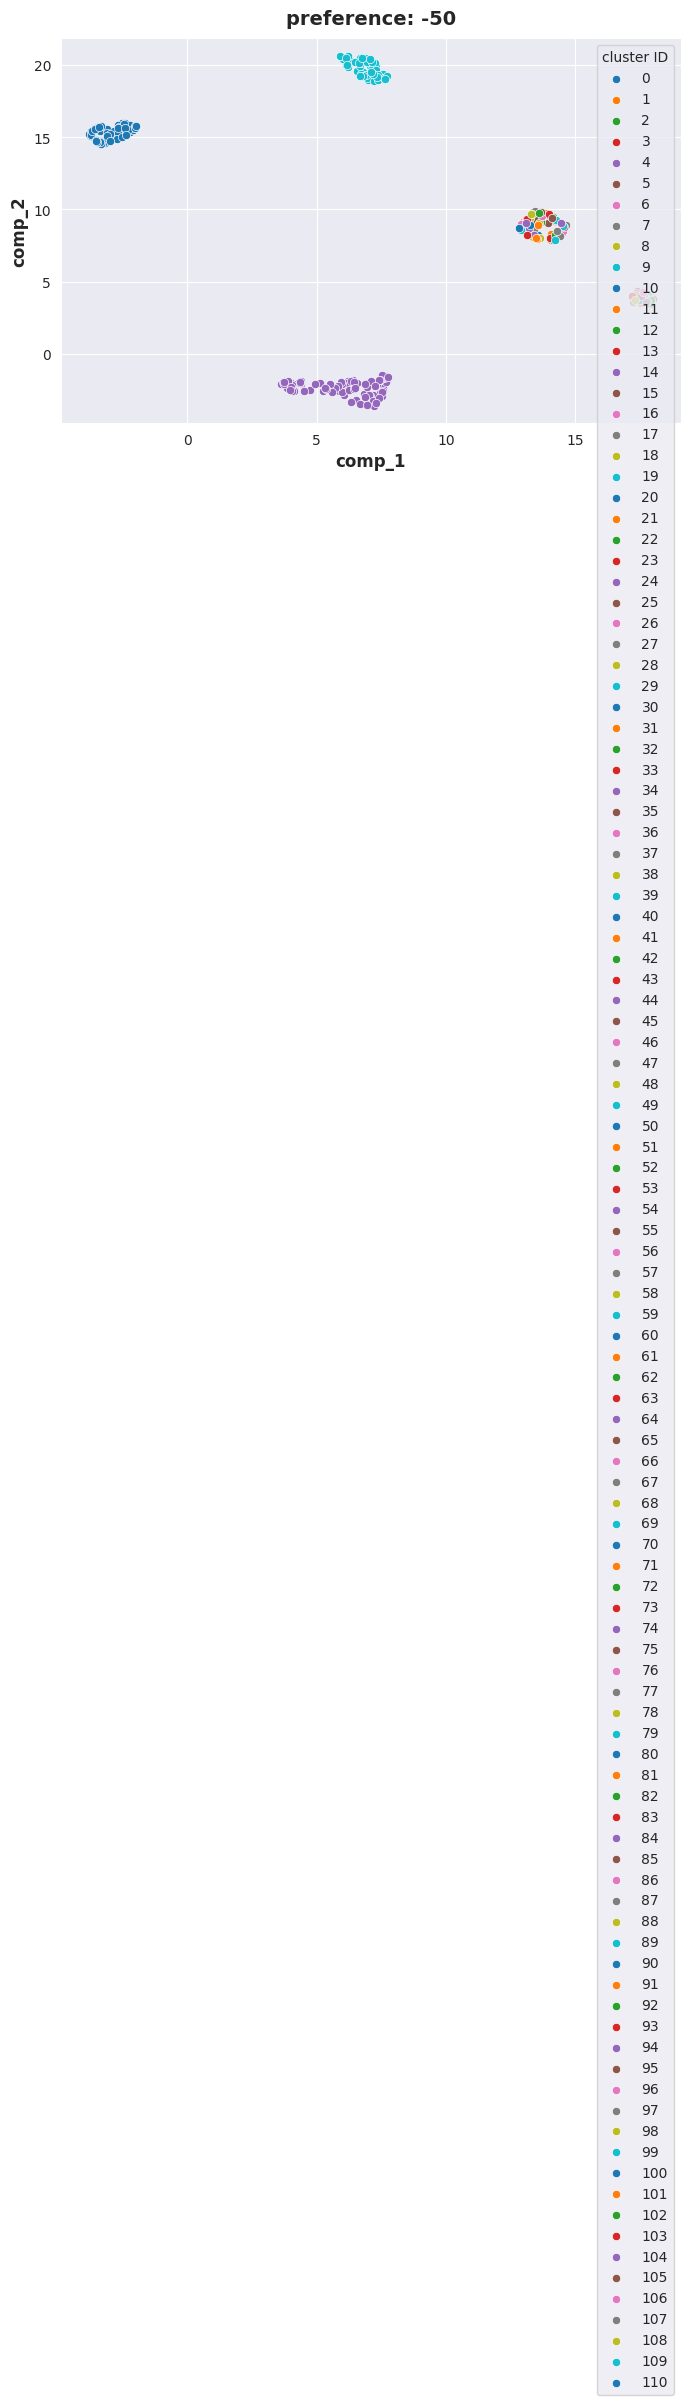

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


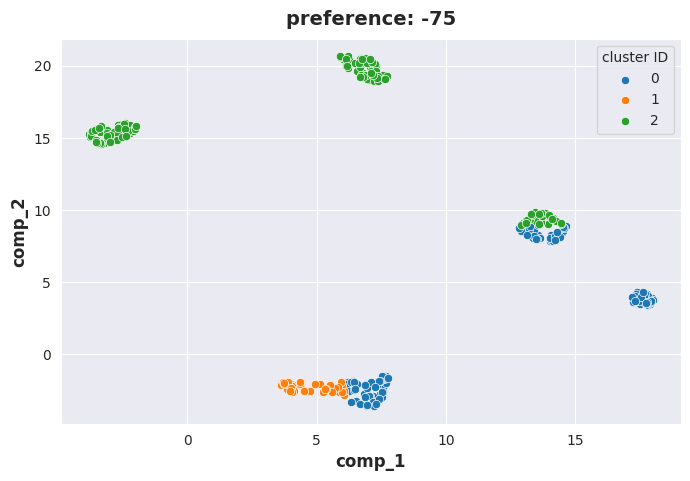

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


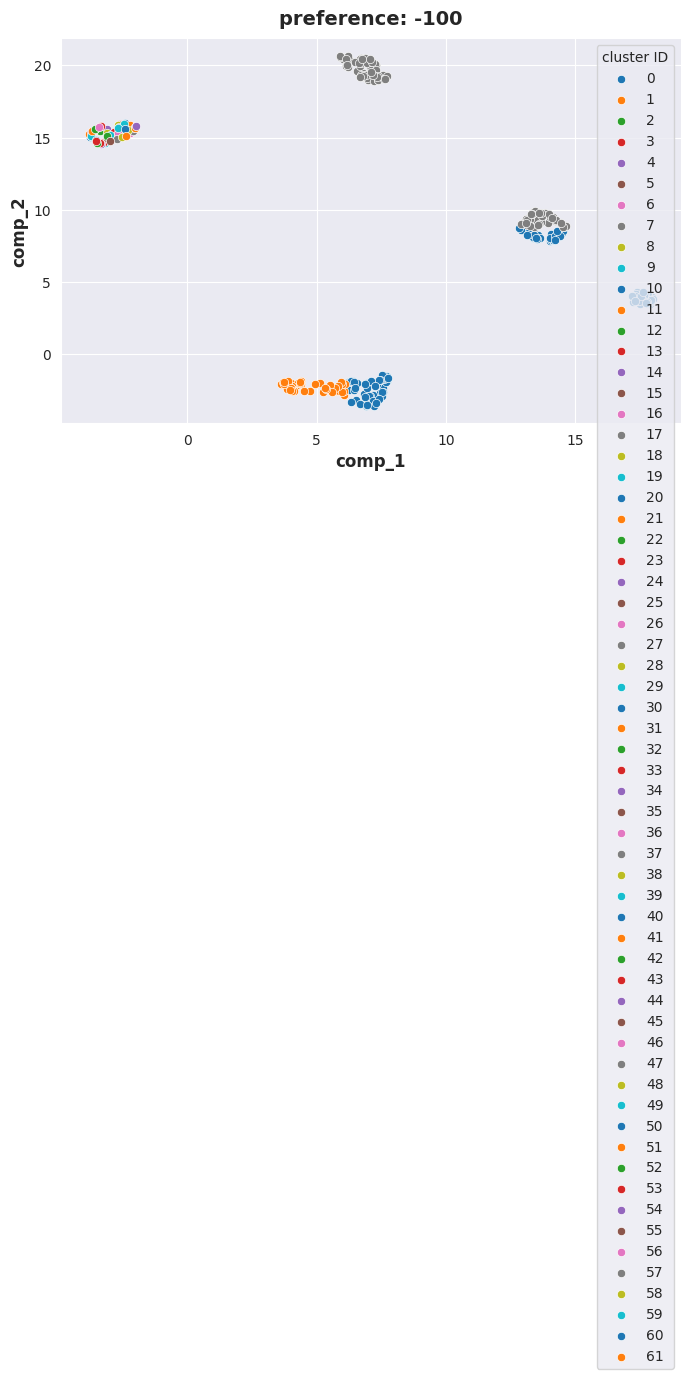


CPU times: user 23.4 s, sys: 792 ms, total: 24.2 s
Wall time: 25.1 s


In [156]:
%%time

prefs = [-10, -25, -50, -75, -100]

for p in prefs:
    affprop = AffinityPropagation(preference=p, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=p, noise_exist=False)
    convergence_check(affprop)

==> In contrast to *damping*, *preference* seems to have a much stronger influcence on the number of formed clusters ***for this particular dataset***.

### Re-run with optimised *preference*

In [157]:
%%time

start_time = time.time()

affprop = AffinityPropagation(preference=-75, max_iter=500, random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

training_times.append(time.time() - start_time)


CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.14 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


## Algo 5: DBSCAN

DBSCAN is a density-based algorithm. It assumes that clusters are of a **roughly similar density**. Its main hyperparameter is ***eps***, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Its default value is 0.5. This algorithm comes with a second important hyperparamter, which is ***min_samples***. It represents the number of samples in a neighborhood for a point to be considered as a core point. *Min_samples* is not tuned in the context of this exercise though.

In contrast to algorithms 1 to 4, DBSCAN is **not iterative but deterministic** in nature. Thus no convergence check is required here.

A core feature of DBSCAN is that it also attempts to identify "**noise**", i.e. data points not associated with any cluster. Those data points are represented in the following plots as blue stars with cluster ID -1.

In [158]:
# hyperparamter to tune

dbscan_hparam = "eps"

### Vanilla run (defaults for all hyperparameters)

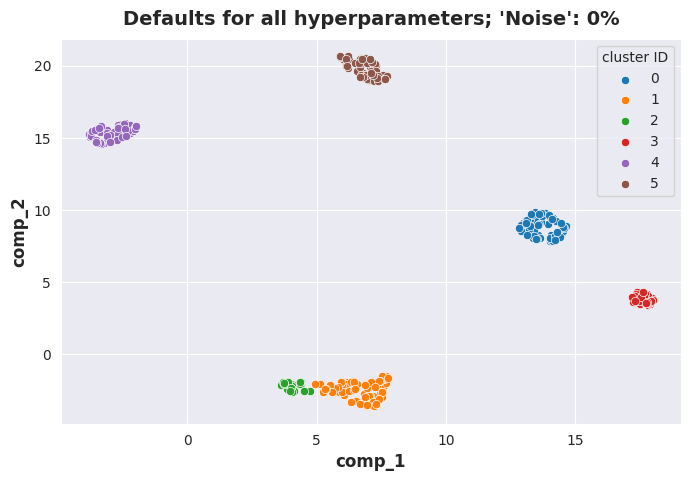

CPU times: user 754 ms, sys: 71.3 ms, total: 826 ms
Wall time: 868 ms


In [159]:
%%time

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The result looks quite convincing! It is important to note here that the structure of data is not at odds with what DBSCAN requires in order to work satisfactorily, i.e. that the **clusters are of a roughly similar density**. Approximately 4% off all datapoints were identified as noise here.

### Tuning runs for *eps*

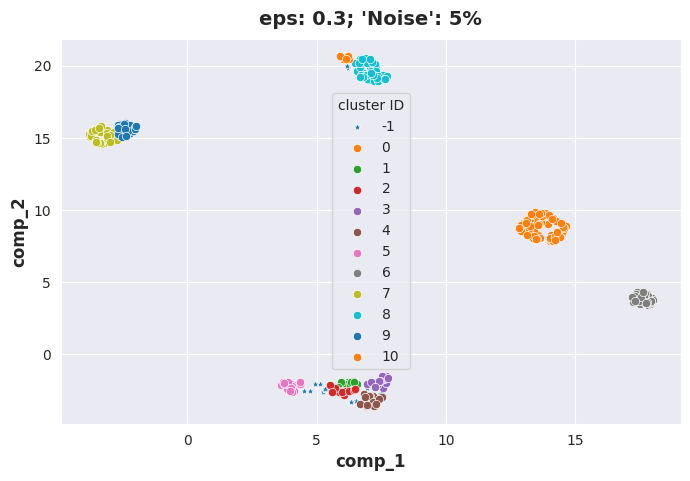

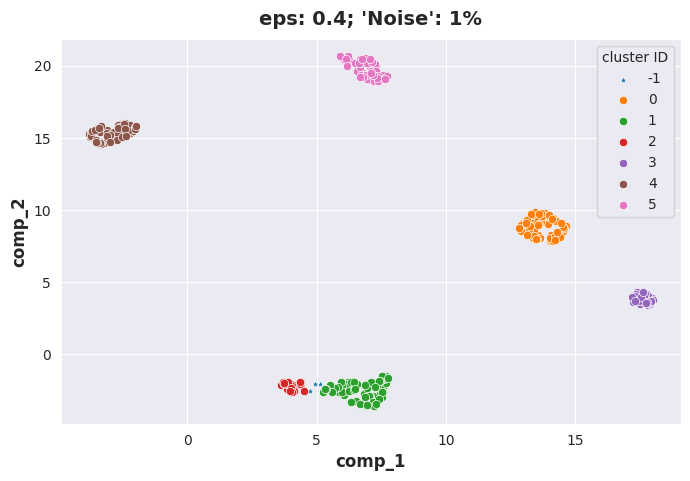

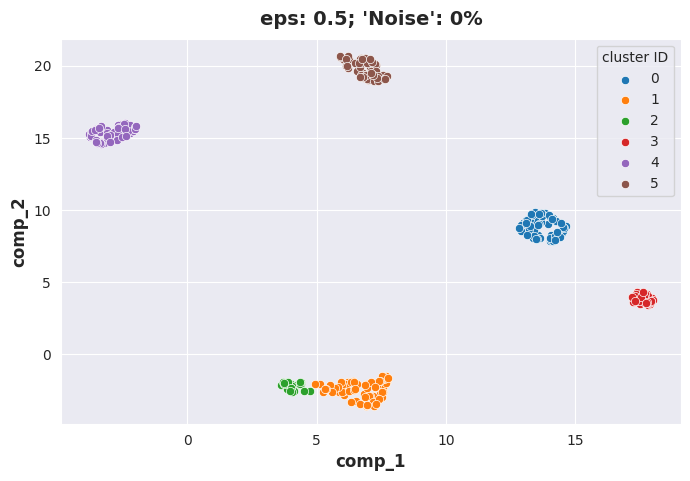

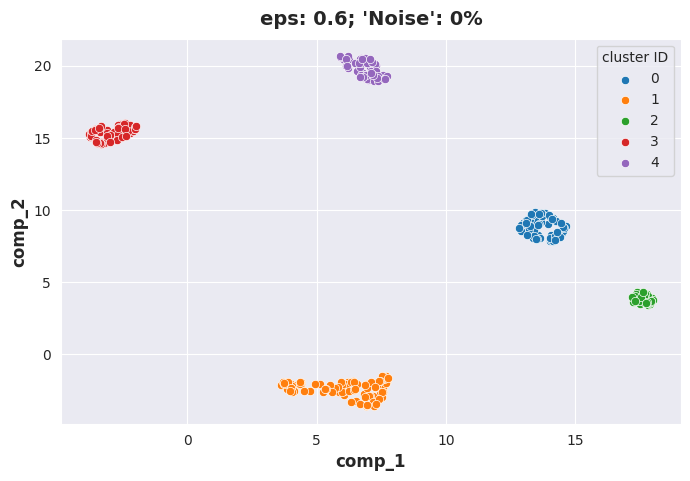

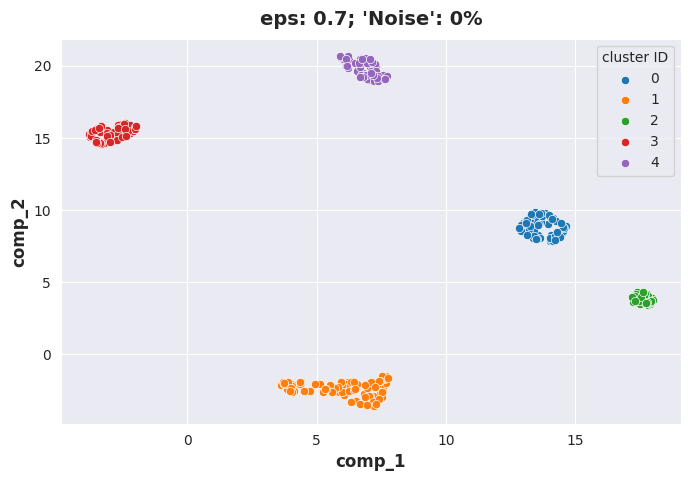

CPU times: user 3.03 s, sys: 453 ms, total: 3.48 s
Wall time: 3.13 s


In [160]:
%%time

for e in [0.3, 0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

==> The algorithm shows quite a high sensitivity to ***eps***. A value of around 0.6 seems to work best for this particular dataset.

### Re-run with optimised *eps*

In [161]:
%%time

eps_val = 0.6

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 10.2 ms, sys: 10 µs, total: 10.3 ms
Wall time: 19.7 ms


## Algo 6: OPTICS

OPTICS can be considered an "advanced" version of DBSCAN. Its key difference to the latter is that OPTICS features a **variable neighborhood radius**. Its main hyperparameter to tune is ***min_samples***, which is the number of samples in a neighborhood for a point to be considered as a core point.

In [162]:
# hyperparamter to tune

optics_hparam = "min_samples"

### Vanilla run (defaults for all hyperparameters)

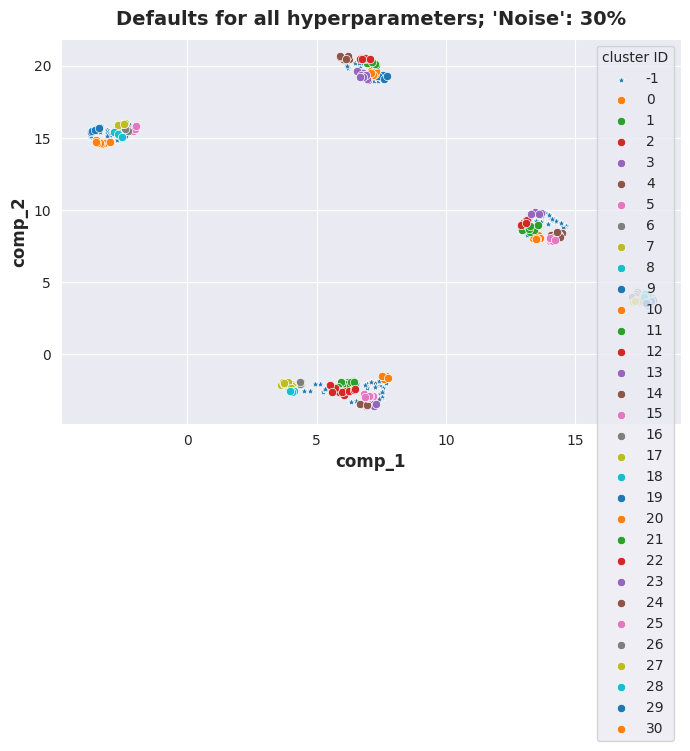

CPU times: user 3.06 s, sys: 503 ms, total: 3.57 s
Wall time: 6.53 s


In [163]:
%%time

optics = OPTICS(n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The algorithm identified a considerable number of clusters. Furthermore, a substantial partion of the dataset is labelled as "noise".

### Tuning runs for *min_samples*

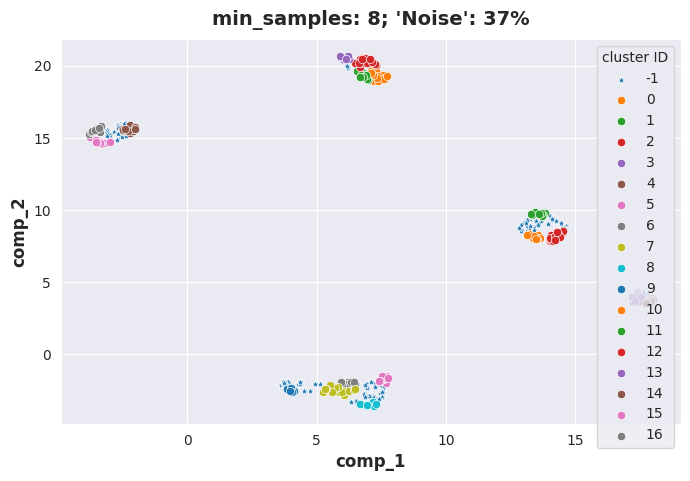

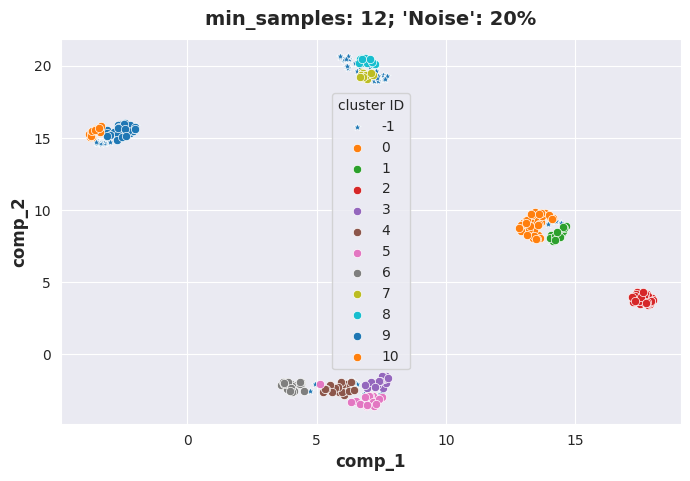

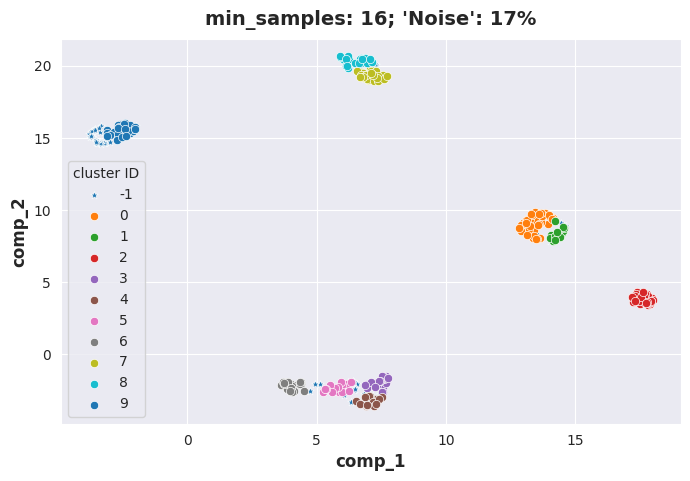

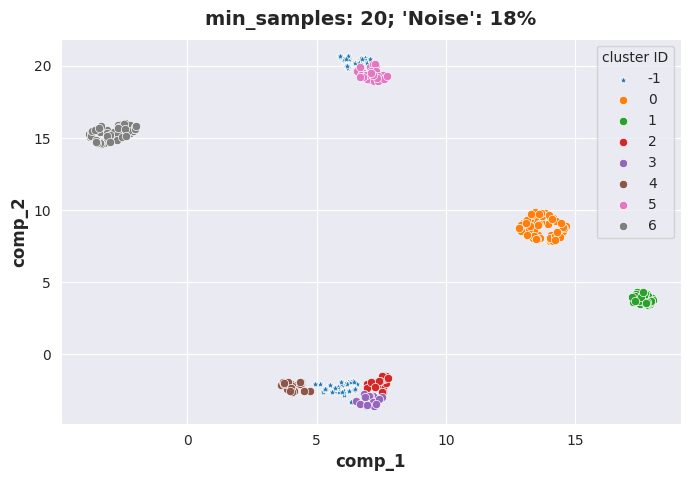

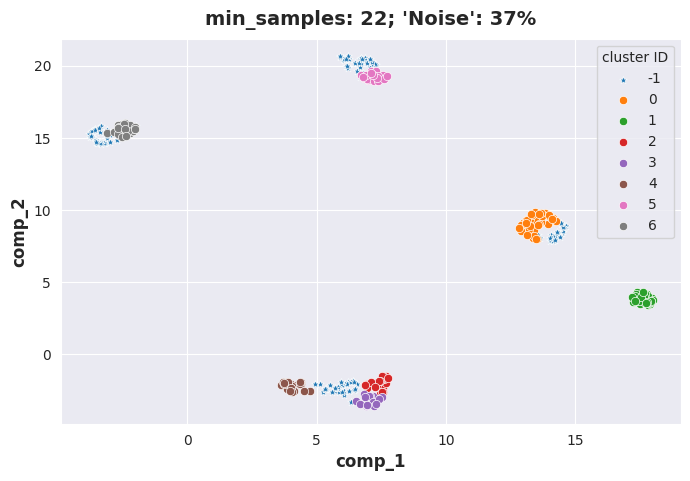

CPU times: user 10.6 s, sys: 2.06 s, total: 12.7 s
Wall time: 28 s


In [164]:
%%time

for n_samples in [8, 12, 16, 20, 22]:

    optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

    labels_6 = optics.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

==> An approprate value for *min_samples* would be around 20.

### Re-run with optimised *min_samples*

In [165]:
%%time

n_samples = 20

start_time = time.time()

optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 1.23 s, sys: 312 ms, total: 1.54 s
Wall time: 4.68 s


# Comparison of training times

['K-means', 'Mean shift', 'Gaussian mixtures', 'Affinity propagation', 'DBSCAN', 'OPTICS'] [0.04361748695373535, 4.8482561111450195, 0.1271364688873291, 1.1349971294403076, 0.019709110260009766, 4.681341648101807]


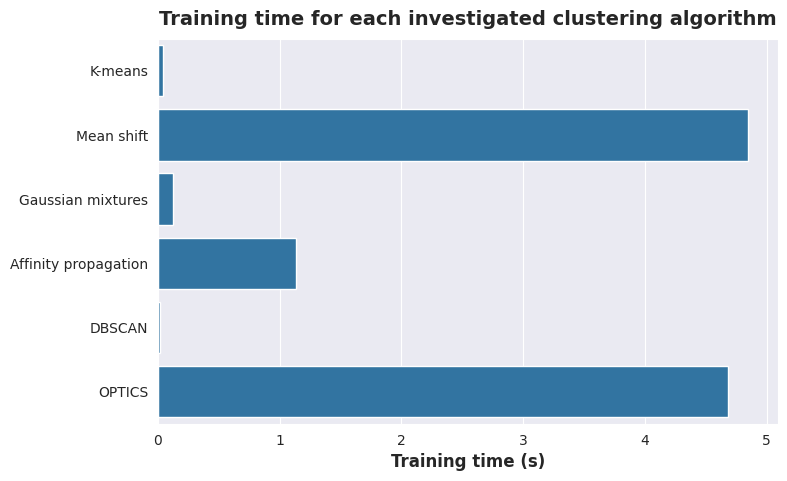

In [166]:
plt.figure(figsize=std_figure_size)
print(algos,training_times)
sns.barplot(y=algos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

==> The training times across the investigated algorithms **vary considerably**! On the scale of the training times for the Mean shift and OPTICS algorithms, the training times of the other algos practically vanish. Interestingly enough though, when allowing for data points to be considered as "noise" for the Mean shift algo, its training time reduced substantially. For the following, its training time for *cluster_all=False* is taken as its relevant time. Furthermore, OPTICS is excluded so to allow for a comparison of the training times of the remaining algos on a more sensible scale.

In [167]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

In [176]:
algos = ['K-means','Gaussian mixtures', 'Affinity propagation', 'DBSCAN','OPTICS','Mean shift']

['K-means', 'Gaussian mixtures', 'Affinity propagation', 'DBSCAN', 'OPTICS', 'Mean shift'] [0.04361748695373535, 0.8359267711639404, 0.1271364688873291, 1.1349971294403076, 0.019709110260009766, 4.681341648101807]


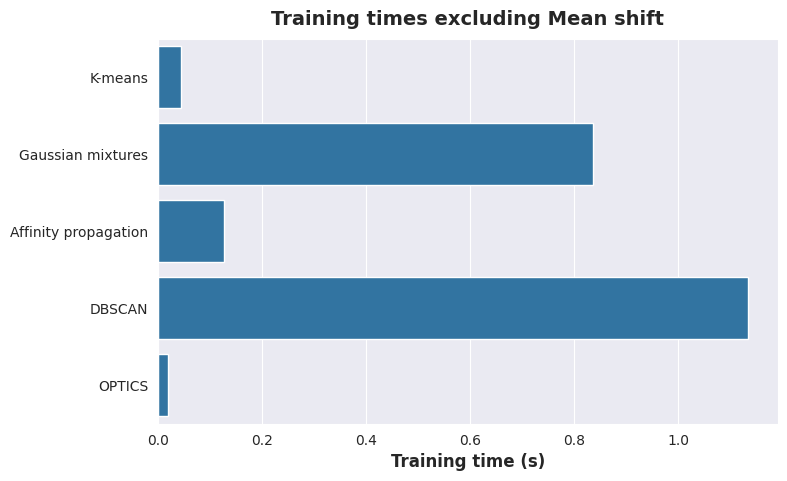

In [177]:
plt.figure(figsize=std_figure_size)
print(algos,training_times)
sns.barplot(y=algos[:-1], x=training_times[:-1])
plt.title("Training times excluding Mean shift")
plt.xlabel("Training time (s)")
plt.show()

# Conclusions

As with practically everything else in the machine learning domain, when it comes to clustering there is no "one-size-fits-all" algorithm. Different algorithms tend to be better depending on the structure of the data and in particluar **to what extent this structure is in line with what each algorithm relies on in order to work satisfactorily**. For the relatively simple data structure of the "wine dataset", practically all investigated algorithms performed well (after more or less hyperparameter turning).

Two important caveats regarding the results of this "study":
- Only the **single "most important" hyperparameter** was considered for tuning for each algorithm.
- The **dataset** employed here is **very small**. For datasets of a more real-world size, the relative performance in terms of training times will most likely be different.